I must first upload my kaggle.json

In [8]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
!kaggle datasets download -d adityakharosekar2/guardian-news-articles

100% 278M/278M [00:03<00:00, 121MB/s]
100% 278M/278M [00:03<00:00, 89.3MB/s]


In [9]:
!pip install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Conv1D, MaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import load_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [11]:
# Specify the path to the zip file
zip_file_path = '/content/guardian-news-articles.zip'

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the files in the zip file to a folder
    zip_ref.extractall('/content')

In [13]:
# Load and preprocess data
data = pd.read_csv('/content/guardian_articles.csv')

In [14]:
data

,article_id,sectionName,webTitle,webUrl,bodyContent,webPublicationDate,id
0,us-news/2016/jan/31/iowa-caucus-underdog-candi...,US news,Iowa underdogs put on brave faces despite all ...,https://www.theguardian.com/us-news/2016/jan/3...,As polling day looms and the cameras turn only...,2016-01-31T23:53:37Z,1
1,us-news/2016/jan/31/iowa-caucus-worlds-most-pa...,US news,Iowa caucus: hologram eagle and Jesus star on ...,https://www.theguardian.com/us-news/2016/jan/3...,"In Des Moines on Sunday, the Guardian was give...",2016-01-31T23:46:28Z,2
2,world/2016/jan/31/tanzania-britsh-helicopter-p...,World news,British pilot in Tanzania 'manoeuvred ​to save...,https://www.theguardian.com/world/2016/jan/31/...,A British pilot who was shot dead by an elepha...,2016-01-31T23:43:48Z,3
3,football/2016/jan/31/late-winner-gets-usa-off-...,Football,USA 3-2 Iceland | International friendly match...,https://www.theguardian.com/football/2016/jan/...,USA took a step toward shaking off the ghosts ...,2016-01-31T23:30:49Z,4
4,football/2016/jan/31/blackburn-paul-lambert-ox...,Football,Reinvigorated Paul Lambert reflects after impr...,https://www.theguardian.com/football/2016/jan/...,"The clean-shaven, spectacle free and suspiciou...",2016-01-31T22:30:10Z,5
...,...,...,...,...,...,...,...
149834,world/2022/jun/21/marble-head-of-hercules-pull...,World news,Marble head of Hercules pulled up from Roman s...,https://www.theguardian.com/world/2022/jun/21/...,"For archaeologists, it’s the underwater find t...",2022-06-21T17:31:32Z,149835
149835,music/2022/jun/22/i-got-sick-of-talking-about-...,Music,‘I got sick of talking about myself’: Spacey J...,https://www.theguardian.com/music/2022/jun/22/...,"From under a mop of curls, Caleb Harper – Spac...",2022-06-21T17:30:09Z,149836
149836,australia-news/2022/jun/22/the-small-town-with...,Australia news,The small town with a big potato that inspired...,https://www.theguardian.com/australia-news/202...,"Robertson is a small, pretty town perched on t...",2022-06-21T17:30:09Z,149837
149837,australia-news/2022/jun/22/power-to-ban-citize...,Australia news,Power to ban citizens from re-entering Austral...,https://www.theguardian.com/australia-news/202...,A high court decision striking down the home a...,2022-06-21T17:30:08Z,149838


In [15]:
data = data[['sectionName', 'bodyContent']]  # Keep only the relevant columns
data = data.dropna()  # Remove rows with missing values
# Select a random 10%-20% portion of the dataset
data_sample = data.sample(frac=0.1, random_state=42)

# Split the dataset into training (80%), validation (10%), and test (10%) sets
train, test = train_test_split(data_sample, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.125, random_state=42)

print("Training samples:", len(train))
print("Validation samples:", len(val))
print("Test samples:", len(test))


Training samples: 10410
Validation samples: 1488
Test samples: 2975


In [16]:
train

,sectionName,bodyContent
97494,World news,Scott Morrison will urge G20 leaders to fund r...
69852,Global development,The fragrant jasmine rice growing on the left ...
74324,UK news,An MI6 officer was discovered to have child se...
51220,Sport,The greatest on-field scandal in the history o...
41914,Business,Let’s hope António Horta-Osório is right. The ...
...,...,...
89785,UK news,The jury at Preston crown court has been sent ...
83369,Politics,A petition calling on the government not to pr...
100105,Opinion,It has been both a curse and a blessing for Ke...
139951,Fashion,The opening of Paris haute couture fashion wee...


In [17]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['bodyContent'])

X_train = tokenizer.texts_to_sequences(train['bodyContent'])
X_val = tokenizer.texts_to_sequences(val['bodyContent'])
X_test = tokenizer.texts_to_sequences(test['bodyContent'])

In [18]:
# Pad the sequences
max_length = 500

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [19]:
# Prepare the target (sectionName) data
encoder = LabelEncoder()
encoder.fit(data_sample['sectionName'])
y_train = encoder.transform(train['sectionName'])
y_val = encoder.transform(val['sectionName'])
y_test = encoder.transform(test['sectionName'])

In [20]:
def build_rnn_model(model_type, state_size):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, state_size, input_length=max_length))
    if model_type == "LSTM":
        model.add(LSTM(state_size))
    elif model_type == "RNN":
        model.add(SimpleRNN(state_size))
    model.add(Dense(len(encoder.classes_), activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model
# LSTM and RNN have been taken from here "https://www.tensorflow.org/guide/keras/rnn"
#this included simple rnn and lstm :)

# Compare LSTM and Basic RNN models
state_size = 128
epochs = 1
batch_size = 32
# I seen people use batch size 32 often I dont know why 32 honestly, when i looked up on google
# I found that "That said, note that for batch size 32 we have the least error rate. We see an exponential increase
# in the time taken to train as we move from higher batch size to lower batch size.24 Mar 2022"
# and i chose 10 epochs because 1 takes around 2-3 min
# I do not have unlimited time... therefore i chose 10 as it took 49min to train :)

# LSTM
lstm_model = build_rnn_model("LSTM", state_size)
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

# RNN
rnn_model = build_rnn_model("RNN", state_size)
rnn_history = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

print("LSTM Test Accuracy:", lstm_test_acc)
print("Basic RNN Test Accuracy:", rnn_test_acc)


326/326 [==============================] - 235s 713ms/step - loss: 3.3566 - accuracy: 0.0957 - val_loss: 3.2903 - val_accuracy: 0.0847
LSTM Test Accuracy: 0.09915966540575027
Basic RNN Test Accuracy: 0.09277310967445374


In [21]:
def build_multi_lstm_model(state_size, num_layers):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, state_size, input_length=max_length))
    for _ in range(num_layers - 1):
        model.add(LSTM(state_size, return_sequences=True))
    model.add(LSTM(state_size))
    model.add(Dense(len(encoder.classes_), activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Compare single-layer and multi-layer LSTM implementations
num_layers = 3
multi_lstm_model = build_multi_lstm_model(state_size, num_layers)
multi_lstm_history = multi_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
multi_lstm_test_loss, multi_lstm_test_acc = multi_lstm_model.evaluate(X_test, y_test, verbose=0)

print("Single-Layer LSTM Test Accuracy:", lstm_test_acc)
print("Multi-Layer LSTM Test Accuracy:", multi_lstm_test_acc)

326/326 [==============================] - 73s 206ms/step - loss: 3.3421 - accuracy: 0.0970 - val_loss: 3.3081 - val_accuracy: 0.0921
Single-Layer LSTM Test Accuracy: 0.09915966540575027
Multi-Layer LSTM Test Accuracy: 0.09478991478681564


In [22]:
train

,sectionName,bodyContent
97494,World news,Scott Morrison will urge G20 leaders to fund r...
69852,Global development,The fragrant jasmine rice growing on the left ...
74324,UK news,An MI6 officer was discovered to have child se...
51220,Sport,The greatest on-field scandal in the history o...
41914,Business,Let’s hope António Horta-Osório is right. The ...
...,...,...
89785,UK news,The jury at Preston crown court has been sent ...
83369,Politics,A petition calling on the government not to pr...
100105,Opinion,It has been both a curse and a blessing for Ke...
139951,Fashion,The opening of Paris haute couture fashion wee...


In [23]:
import tensorflow_hub as hub
import ssl

# Load pre-trained word embeddings
try:
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2", ssl_context=ctx)
    embeddings_layer = hub.KerasLayer(embed, input_shape=[], dtype=tf.string, trainable=True)

except Exception as e:
    print("Error loading pre-trained embeddings:", e)
    embeddings_layer = None

# Preprocess text data for pre-trained embeddings
X_train_str = train['bodyContent'].values
X_val_str = val['bodyContent'].values
X_test_str = test['bodyContent'].values

# Build and compile the embedding model
def build_embedding_model(use_pretrained_embeddings):
    model = tf.keras.Sequential()
    if use_pretrained_embeddings and embeddings_layer is not None:
        model.add(embeddings_layer)
    else:
        model.add(tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, state_size, input_length=max_length))
    model.add(tf.keras.layers.LSTM(state_size))
    model.add(tf.keras.layers.Dense(len(encoder.classes_), activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model



Error loading pre-trained embeddings: load() got an unexpected keyword argument 'ssl_context'


# Compare classification between embeddings learned on the fly and pre-trained

In [24]:
# Embeddings learned on the fly
embedding_model_fly = build_embedding_model(False)
embedding_fly_history = embedding_model_fly.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
embedding_fly_test_loss, embedding_fly_test_acc = embedding_model_fly.evaluate(X_test, y_test, verbose=0)


326/326 [==============================] - 58s 171ms/step - loss: 3.3388 - accuracy: 0.1009 - val_loss: 3.2783 - val_accuracy: 0.0827


In [25]:
# Pre-trained word embeddings
embedding_model_pretrained = build_embedding_model(True)
embedding_pretrained_history = embedding_model_pretrained.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
embedding_pretrained_test_loss, embedding_pretrained_test_acc = embedding_model_pretrained.evaluate(X_test, y_test, verbose=0)

326/326 [==============================] - 54s 160ms/step - loss: 3.3342 - accuracy: 0.0966 - val_loss: 3.2635 - val_accuracy: 0.0921


In [26]:
print("Embeddings learned on the fly Test Accuracy:", embedding_fly_test_acc)
print("Pre-trained word embeddings Test Accuracy:", embedding_pretrained_test_acc)

Embeddings learned on the fly Test Accuracy: 0.09815125912427902
Pre-trained word embeddings Test Accuracy: 0.09478991478681564


In [27]:
def build_cnn_model(use_cnn_before_lstm):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, state_size, input_length=max_length))
    if use_cnn_before_lstm:
        model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(state_size))
    model.add(Dense(len(encoder.classes_), activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Use of CNN as an alternative to LSTM
cnn_model = build_cnn_model(False)
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test, verbose=0)

# Use of CNN as an additional layer before LSTM
cnn_lstm_model = build_cnn_model(True)
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
cnn_lstm_test_loss, cnn_lstm_test_acc = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

print("CNN as an alternative to LSTM Test Accuracy:", cnn_test_acc)
print("CNN as an additional layer before LSTM Test Accuracy:", cnn_lstm_test_acc)


326/326 [==============================] - 57s 152ms/step - loss: 3.3253 - accuracy: 0.0972 - val_loss: 3.2731 - val_accuracy: 0.0974
CNN as an alternative to LSTM Test Accuracy: 0.09478991478681564
CNN as an additional layer before LSTM Test Accuracy: 0.10319327563047409


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Compare the performance of the best performing neural model against Naive Bayes
vectorizer = TfidfVectorizer()
clf = MultinomialNB()

text_clf = make_pipeline(vectorizer, clf)
text_clf.fit(train['bodyContent'], y_train)
naive_bayes_test_acc = text_clf.score(test['bodyContent'], y_test)

best_neural_acc = max([lstm_test_acc, rnn_test_acc, multi_lstm_test_acc, embedding_fly_test_acc, embedding_pretrained_test_acc, cnn_test_acc, cnn_lstm_test_acc])


print("Best Neural Model Test Accuracy:", best_neural_acc)
print("Naive Bayes Test Accuracy:", naive_bayes_test_acc)


Best Neural Model Test Accuracy: 0.10319327563047409
Naive Bayes Test Accuracy: 0.26857142857142857


In [29]:
import pandas as pd
data_2 = pd.read_csv('/content/guardian_articles.csv')
# Select a random 10%-20% portion of the dataset
data_2 = data_2[['bodyContent', 'webTitle']]  # Keep only the relevant columns
data_2 = data_2.dropna()  # Remove rows with missing values

data_sample_2 = data_2.sample(frac=0.1, random_state=42)

# Split the dataset into training (80%), validation (10%), and test (10%) sets
train_2, test_2 = train_test_split(data_sample_2, test_size=0.2, random_state=42)
train_2, val_2 = train_test_split(train_2, test_size=0.125, random_state=42)

print("Training samples:", len(train_2))
print("Validation samples:", len(val_2))
print("Test samples:", len(test_2))


Training samples: 10410
Validation samples: 1488
Test samples: 2975


In [30]:
# Build a model that uses both the text of an article and the web title to predict the section heading
X_train_both = train_2['bodyContent'] + ' ' + train_2['webTitle']
X_val_both = val_2['bodyContent'] + ' ' + val_2['webTitle']
X_test_both = test_2['bodyContent'] + ' ' + test_2['webTitle']

# Tokenize the combined text and title data
X_train_both = tokenizer.texts_to_sequences(X_train_both)
X_val_both = tokenizer.texts_to_sequences(X_val_both)
X_test_both = tokenizer.texts_to_sequences(X_test_both)

# Pad the sequences
X_train_both = pad_sequences(X_train_both, maxlen=max_length, padding="post")
X_val_both = pad_sequences(X_val_both, maxlen=max_length, padding="post")
X_test_both = pad_sequences(X_test_both, maxlen=max_length, padding="post")

# Train model with both text and title data
both_model = build_rnn_model("LSTM", state_size)
both_history = both_model.fit(X_train_both, y_train, validation_data=(X_val_both, y_val), epochs=epochs, batch_size=32)
both_test_loss, both_test_acc = both_model.evaluate(X_test_both, y_test, verbose=0)

print("Model with both text and web title Test Accuracy:", both_test_acc)


326/326 [==============================] - 53s 156ms/step - loss: 3.3020 - accuracy: 0.1212 - val_loss: 3.1393 - val_accuracy: 0.1458
Model with both text and web title Test Accuracy: 0.16470588743686676


In [31]:
# Save two models: the best model obtained without pre-trained embeddings and the best model obtained with pre-trained embeddings
models = {
    "lstm": lstm_test_acc,
    "rnn": rnn_test_acc,
    "multi_lstm": multi_lstm_test_acc,
    "embedding_fly": embedding_fly_test_acc,
    "embedding_pretrained": embedding_pretrained_test_acc,
    "cnn": cnn_test_acc,
    "cnn_lstm": cnn_lstm_test_acc,
    "both": both_test_acc
}

best_model_no_pretrained = max(models, key=lambda x: models[x] if x != "embedding_pretrained" else -1)
best_model_pretrained = "embedding_pretrained"

# Save the best models
lstm_model.save(f"best_model_no_pretrained_{best_model_no_pretrained}.h5")
embedding_model_pretrained.save("best_model_pretrained_embedding.h5")

print(f"Best model without pre-trained embeddings: {best_model_no_pretrained}.h5")
print("Best model with pre-trained embeddings: best_model_pretrained_embedding.h5")


Best model without pre-trained embeddings: both.h5
Best model with pre-trained embeddings: best_model_pretrained_embedding.h5


In [34]:
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    # Set up early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    
    # Evaluate the model
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    
    print(f'Training accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}')
    print(f'Training loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')
    
    return history

Epoch 1/2
326/326 [==============================] - 53s 158ms/step - loss: 3.1822 - accuracy: 0.1216 - val_loss: 3.0902 - val_accuracy: 0.1304
Epoch 2/2
326/326 [==============================] - 31s 97ms/step - loss: 2.9143 - accuracy: 0.1990 - val_loss: 3.0157 - val_accuracy: 0.1418
Training accuracy: 0.2449, Validation accuracy: 0.1418
Training loss: 2.6594, Validation loss: 3.0157


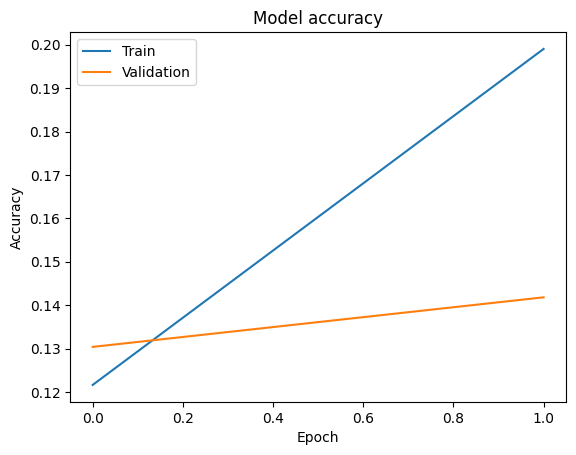

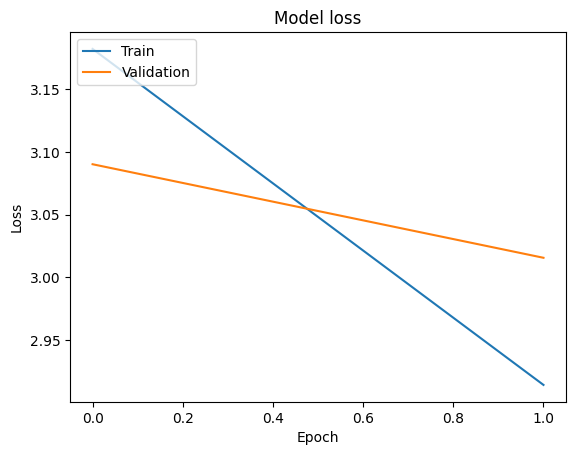

Epoch 1/2
326/326 [==============================] - 55s 164ms/step - loss: 3.2174 - accuracy: 0.1159 - val_loss: 3.2935 - val_accuracy: 0.0914
Epoch 2/2
326/326 [==============================] - 31s 95ms/step - loss: 3.0435 - accuracy: 0.1663 - val_loss: 3.1696 - val_accuracy: 0.1384
Training accuracy: 0.2352, Validation accuracy: 0.1384
Training loss: 2.8106, Validation loss: 3.1696


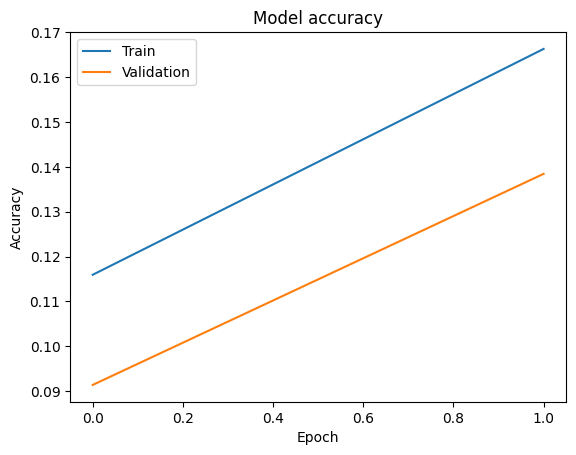

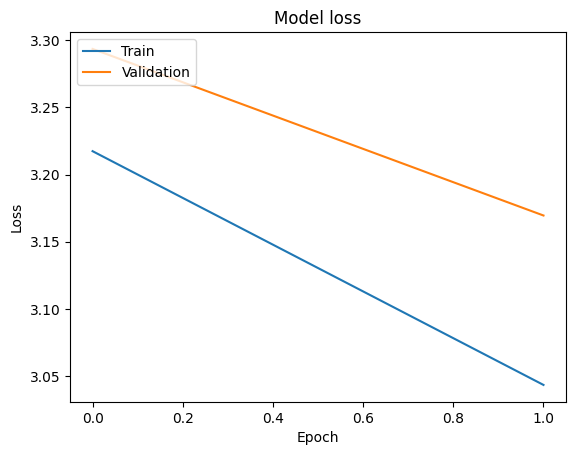

In [35]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Load the saved models
best_model_no_pretrained = load_model('/content/best_model_no_pretrained_both.h5')
best_model_pretrained = load_model('/content/best_model_pretrained_embedding.h5')

# Train and evaluate the model without pre-trained embeddings
history_no_pretrained = train_and_evaluate_model(best_model_no_pretrained, X_train, y_train, X_val, y_val, epochs=2, batch_size=32)
plot_history(history_no_pretrained)

# Train and evaluate the model with pre-trained embeddings
history_pretrained = train_and_evaluate_model(best_model_pretrained, X_train, y_train, X_val, y_val, epochs=2, batch_size=32)
plot_history(history_pretrained)